<img src="http://aif360.mybluemix.net/static/images/logo.png" width="100" align="left">



#  &nbsp;&nbsp;&nbsp; Beyond Accuracy: Fairness in Machine Learning


**November 2020 -  Margriet Groenendijk** 

*Notebook for the [Digital Developer Conference - Data & AI](https://developer.ibm.com/conferences/digital-developer-conference-data-ai)*

Full instructions on how to run this notebook in Watson Studio are [here](https://ibm-developer.gitbook.io/fair-and-explainable-ai/beyond-accuracy)

*Code from [these examples](https://github.com/Trusted-AI/AIF360/tree/master/examples) is used and adapted*

## Description

Building accurate machine learning models is not always good enough, especially when predictions are used to make decisions that impact peoples lives. In addition, the fairness of a model becomes very important when decisions need be fully trusted.

This notebook gives practical examples to define and quantify the fairness of both data and models, exploring algorithms to detect bias and disparity in data, and mitigate bias in both data and models.

Go through the notebook to get to know more about the fairness concepts and how to explore bias in your own data and models. You will learn about the definitions and algorithms of bias and how to apply them.

## Outline

In this session debiasing techniques will be explored that can be implemented by using the open source toolkit [AI Fairness 360](https://github.com/IBM/AIF360). 

[1. Introduction](#intro)

[2. AI fairness metrics](#metrics)

* [2.1 Install aif360 and import packages](#install)
* [2.2 Exploring data](#explore)
* [2.3 Exploring bias metrics](#bias)

[3. Model building](#model)
 
* [3.1 Train on the original data](#original) 
 
[4. AI fairness algorithms](#algorithms)

* [4.1 Pre-processing](#preproc)
* [4.2 In-processing](#inproc)
* [4.3 Post-processing](#postproc)

[5. More resources](#resources)

<a class="anchor" id="intro"></a>
# 1. Introduction

<div class="alert alert-danger">
 <b>In the UK this happened...</b> 
</div>

* A model was used to estimate students grades
* Based on previous grades, the school they went, the average for the school, etc.
* Impacting the chance of getting accepted by universities

<img src="https://github.com/MargrietGroenendijk/gitbooks2/blob/master/files/Alevels.png?raw=true" width="1000" align="left">

<div class="alert alert-success">
 <b>This model might have been accurate. But is this fair?</b> 
</div>

<div class="alert alert-info">
 <b>How can you avoid this?</b> 
</div>

<div class="alert alert-danger">
 <b>Let's explore fairness, and how to define and reduce bias in data and models</b> 
</div>

<a class="anchor" id="metrics"></a>
# 2. AI fairness metrics

Throughout this notebook [aif360](https://github.com/Trusted-AI/AIF360) is used. This is a Python package that includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models. Find more resources and an interactive demo [here](http://aif360.mybluemix.net/).

<a class="anchor" id="install"></a>
## 2.1 Install aif360  and import packages

To run this notebook in Watson Studio, you first have to install the following packages. 

>NOTE: for other environments you can find more detailed installation instructions [here](https://github.com/Trusted-AI/AIF360#python).

#### Install the packages by uncommenting the following three lines and then running the cell:

In [1]:
#!pip install aif360
#!pip install cvxpy
#!pip install tqdm

#### Import all packages that will be used in this notebook:

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.insert(1, "../")  

# data exploration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(0)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# aif360 data, metrics and algorithms
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

from IPython.display import Markdown, display
%matplotlib inline

pip install 'aif360[LFR]'


<a class="anchor" id="explore"></a>
## 2.2 Exploring data

A [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) with good or bad credit risks described by a set of attributes will be used for the examples in this notebook.

This is one of the [datasets](https://aif360.readthedocs.io/en/latest/modules/datasets.html#module-aif360.datasets) used in `aif360` and has it's own [class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.GermanDataset.html#aif360.datasets.GermanDataset). 

### Load data

When loading the data into the notebook with `aif360` it is assumed that the file can be accessed from a specific location. 

#### Create a folder and then download the data into this new folder if it is not there:
(This will work both locally and on Watson Studio)

In [4]:
aif360_location = !python -c "from distutils.sysconfig import get_python_lib; print(get_python_lib())"
import os
install_loc = os.path.join(aif360_location[0], "aif360/data/raw/german/")
%cd $install_loc

/opt/anaconda3/envs/aif360/lib/python3.6/site-packages/aif360/data/raw/german


In [5]:
!wget -N ftp://ftp.ics.uci.edu/pub/machine-learning-databases/statlog/german/german.data
!wget -N ftp://ftp.ics.uci.edu/pub/machine-learning-databases/statlog/german/german.doc
%cd -

--2020-10-23 00:21:30--  ftp://ftp.ics.uci.edu/pub/machine-learning-databases/statlog/german/german.data
           => ‘.listing’
Resolving ftp.ics.uci.edu (ftp.ics.uci.edu)... 128.195.1.14
Connecting to ftp.ics.uci.edu (ftp.ics.uci.edu)|128.195.1.14|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/machine-learning-databases/statlog/german ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]     396  --.-KB/s    in 0.01s   

2020-10-23 00:21:32 (40.3 KB/s) - ‘.listing’ saved [396]

Removed ‘.listing’.
Remote file no newer than local file ‘german.data’ -- not retrieving.
--2020-10-23 00:21:32--  ftp://ftp.ics.uci.edu/pub/machine-learning-databases/statlog/german/german.doc
           => ‘.listing’
Resolving ftp.ics.uci.edu (ftp.ics.uci.edu)... 128.195.1.14
Connecting to ftp.ics.uci.edu (ftp.ics.uci.edu)|128.195.1.14|:21... connected.
Logging in as anonymou

#### Load the data:

In [6]:
dataset_german = GermanDataset()

#### `type` of the data object:

In [7]:
type(dataset_german)

aif360.datasets.german_dataset.GermanDataset

### AIF360 data format

All variables of this dataset are described in the [documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.GermanDataset.html) with more details in the description of the [`StandardDataset`](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.StandardDataset.html). In short, the dataset class contains a numpy array or pandas DataFrame with several additional variables. 

#### Print a few more details of the data:

In [8]:
print(f'features type: {type(dataset_german.features)}')
print(f'labels: {dataset_german.label_names}')
print(f'protected attributes: {dataset_german.protected_attribute_names}')
print(f'number of features: {len(dataset_german.feature_names)}')

features type: <class 'numpy.ndarray'>
labels: ['credit']
protected attributes: ['sex', 'age']
number of features: 58


In [9]:
print(f'feature names: {dataset_german.feature_names}')

feature names: ['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telepho

#### Or access the help directly in the notebook:

In [10]:
dataset_german?

### Explore with pandas

#### Convert the data to a `features` DataFrame and `labels` Series:

In [11]:
features = pd.DataFrame(dataset_german.features, columns=dataset_german.feature_names)
labels = pd.Series(dataset_german.labels.ravel(), name=dataset_german.label_names[0])

In [12]:
features.describe().transpose().head(12)

,count,mean,std,min,25%,50%,75%,max
month,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
investment_as_income_percentage,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,0.810,0.392497,0.0,1.0,1.0,1.00,1.0
number_of_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
people_liable_for,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0
sex,1000.0,0.690,0.462725,0.0,0.0,1.0,1.00,1.0
status=A11,1000.0,0.274,0.446232,0.0,0.0,0.0,1.00,1.0
status=A12,1000.0,0.269,0.443662,0.0,0.0,0.0,1.00,1.0


[This dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) is already pretty tidy. No missing values and the categorical features are converted into integers. 

>*Attribute 1*: (qualitative) \
>Status of existing checking account \
>A11 : ... < 0 DM \
>A12 : 0 <= ... < 200 DM \
>A13 : ... >= 200 DM / salary assignments for at least 1 year \
>A14 : no checking account 

#### The label values are:

In [13]:
labels.unique()

array([1., 2.])

where 1 = Good, 2 = Bad

### Feature distribution

#### Plot histograms:

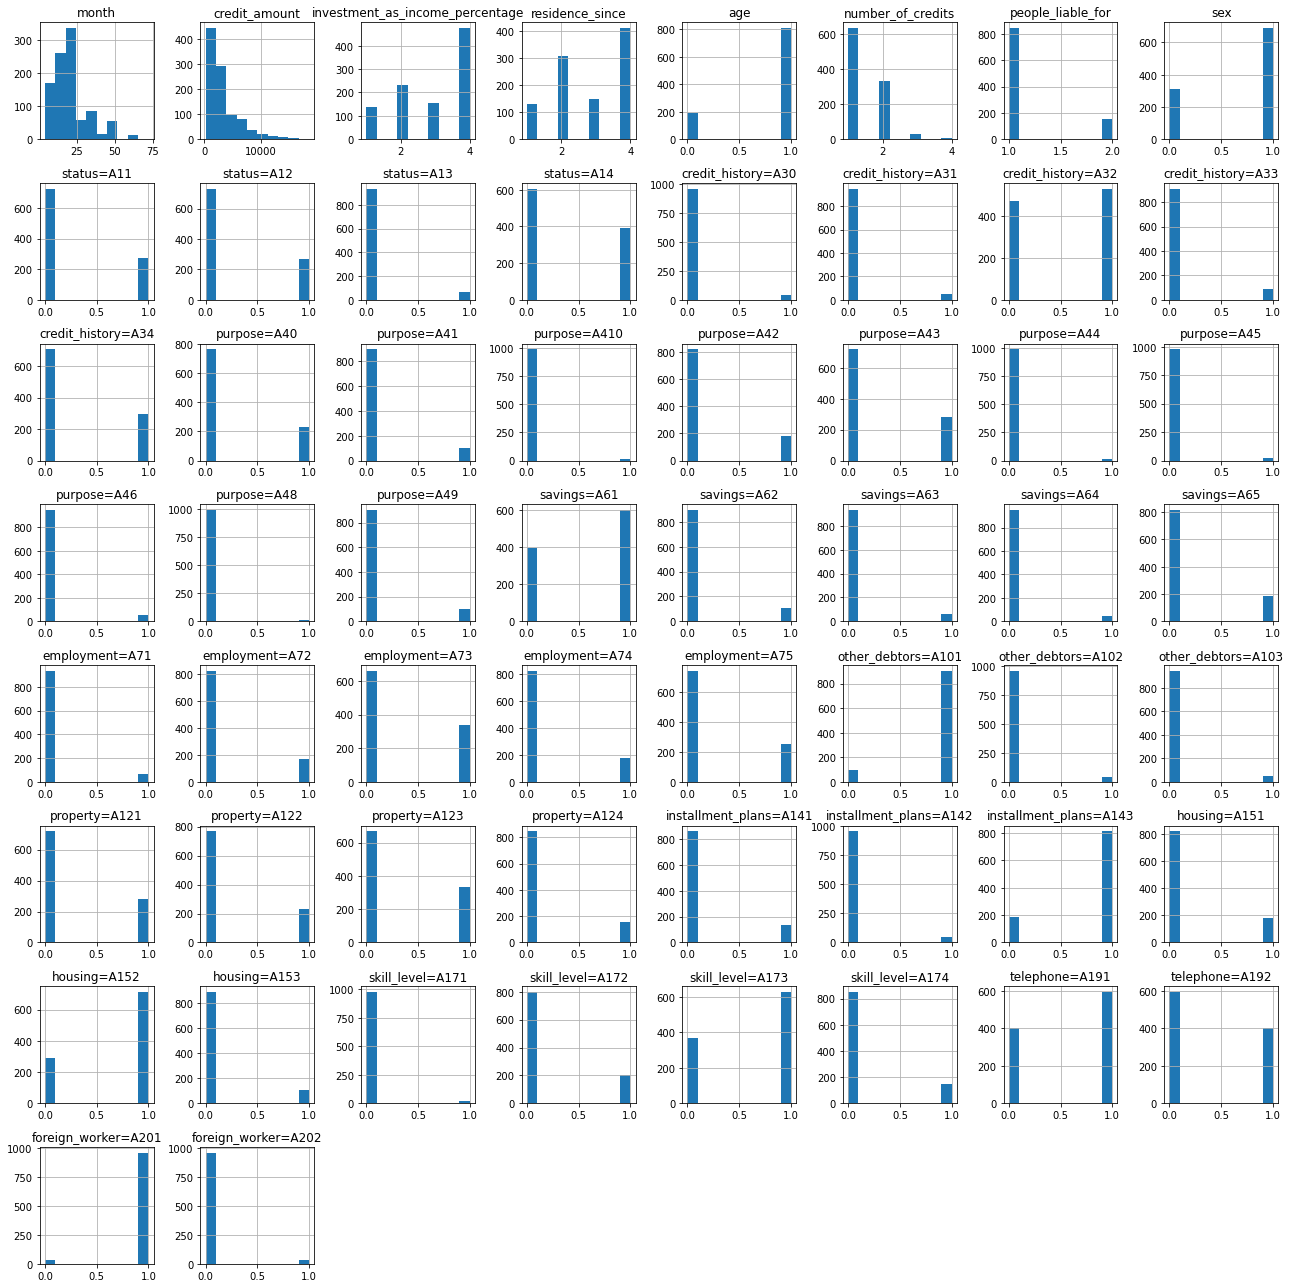

In [14]:
plt.rcParams["figure.figsize"] = (18,18)

features.hist();
plt.tight_layout()

<a class="anchor" id="bias"></a>
## 3.3 Exploring bias metrics

### Bias metrics

> Read <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html">the documentation</a> for a full overview of this class and a list of all bias metrics. <a href="http://aif360.mybluemix.net/data">This demo</a> provides explanations and definitions of the metrics as well.<br>


#### Group Fairness

* Partitions a population into groups defined by protected attributes and seeks for some statistical measure to be equal across groups
* Use the metrics in the [DatasetMetric class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.DatasetMetric.html)

#### Individual Fairness

* Seeks for similar individuals to be treated similarly
* Use the metrics in the [SampleDistortionMetric class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.SampleDistortionMetric.html)

#### Or Both

* Use the generalized entropy index and its specializations to Theil index and coefficient of variation in the [ClassificationMetric class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html)
* Multiple metrics, including ones from both individual and group fairness can be examined simultaneously

### Opposing worldviews on group fairness

#### We are All Equal (WAE)

* All groups have similar abilities with respect to the task (even if we cannot observe this properly)
* For example in university admissions, using grades as a feature for predicting success
    * the grades may contain structural biases so its distribution being different across groups should not be mistaken for a difference in distribution in ability
* Use the demographic parity metrics: `disparate_impact` and `statistical_parity_difference`


#### What You See Is What You Get (WYSIWYG) 

* The observations reflect ability with respect to the task
* For example in university admissions, using grades as a feature for predicting success
    * the grades correlate well with future success
    * there is a way to use the score to correctly compare the abilities of applicants
* Use the equality of odds metrics: `average_odds_difference` and `average_abs_odds_difference`

#### Equality of opportunity
* Other group fairness metrics lie in-between the two worldviews: `false_negative_rate_ratio`, `false_negative_rate_difference`, `false_positive_rate_ratio`, `false_positive_rate_difference`, `false_discovery_rate_ratio`, `false_discovery_rate_difference`, `false_omission_rate_ratio`, `false_omission_rate_difference`, `error_rate_ratio`, and `error_rate_difference`.

<img src="https://github.com/MargrietGroenendijk/gitbooks2/blob/master/files/metrics.png?raw=true" width="1000" align="left">

* `mean_difference`: (alias of `statistical_parity_difference`)
    * difference of the rate of favorable outcomes received by the unprivileged group to the privileged group 
    * a negative value indicates less favorable outcomes for the unprivileged groups
    * the ideal value of this metric is 0
    * fairness for this metric is between -0.1 and 0.1
    
* `disparate_impact`: ratio of rate of favorable outcome for the unprivileged group to that of the privileged group
     
* `equal_opportunity_difference`: (alias of `true_positive_rate_difference`): 
    * `true_positive_rate`(unprivileged) - `true_positive_rate`(privileged)
    * `true_positive_rate`: ratio of true positives to positive examples in the dataset
     
* `base_rate`: number of positives divided by number of positives plus negatives



### Bias in the credit dataset

In the German dataset bias could occur based on age or sex. To explore the age bias: 

* set the protected attribute to be `age`, where `age >=25` is considered privileged
* the protected attribute for `sex` is not consider in this evaluation
* set two variables for the privileged (1) and unprivileged (0) values for the age attribute. These are key inputs for detecting and mitigating bias
* split the original dataset into training and testing datasets

<div class="alert alert-success">
 <b>OPTIONAL EXERCISE</b> <br/> 
 To explore the gender bias in this dataset, edit the below code to use `sex` as the protected attribute and assign new privileged and unprivileged groups.
</div>

#### Calculate and display the metrics available through the [BinaryLabelDatasetMetric class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html):

In [15]:
dataset_german = GermanDataset(protected_attribute_names=['age'],
                    privileged_classes=[lambda x: x >= 25],      
                    features_to_drop=['personal_status', 'sex']) 

dataset_german_train, dataset_german_test = dataset_german.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [16]:
metric_german_train = BinaryLabelDatasetMetric(dataset_german_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_german_test = BinaryLabelDatasetMetric(dataset_german_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [17]:
#metric_german_train?

In [18]:
display(Markdown("#### Original training dataset"))
print("mean_difference = %f" % metric_german_train.mean_difference())
print("disparate_impact = %f" % metric_german_train.disparate_impact())
print("base_rate = %f" % metric_german_train.base_rate())
print("num_negatives = %f" % metric_german_train.num_negatives())
print("num_positives = %f" % metric_german_train.num_positives())

#### Original training dataset

mean_difference = -0.169905
disparate_impact = 0.766430
base_rate = 0.700000
num_negatives = 210.000000
num_positives = 490.000000


<a class="anchor" id="model"></a>
## 4. Model building

The basics of how a model is created in a supervised machine learning process helps to understand how bias can enter a machine learning model:

<img src="https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/images/Complex_NoProc_V3.jpg"   width="500" align="left">

Bias can enter the system in any of these three steps:

>1. The process starts with a training dataset, which contains a sequence of instances, where each instance has two components: the features and the correct prediction for those features. 
>2. A machine learning algorithm is trained on this training dataset to produce a machine learning model. This generated model can be used to make a prediction when given a new instance. 
>3. A second dataset with features and correct predictions, called a test dataset, is used to assess the accuracy of the model. Since this test dataset is the same format as the training dataset, a set of instances of features and prediction pairs, often these two datasets derive from the same initial dataset. A random partitioning algorithm is used to split the initial dataset into training and test datasets.

* The **training data** set may be biased in that its outcomes may be biased towards particular kinds of instances
* The **algorithm** that creates the model could be biased in that it may generate models that are weighted towards particular features in the input
* The **test data** set could be biased as it can have expectations on correct answers that may be biased

There are also the three points in the machine learning process for testing and mitigating bias:

* pre-processing 
* in-processing
* post-processing

### Binary Classification

Some of the model options:
* Logistic regression
* Decision trees
* Random forests
* Bayesian networks
* Support vector machines
* Neural networks

<div class="alert alert-info" style="font-size:100%">
<b>If you are new to scikit-learn read this <a href="https://developer.ibm.com/series/learning-path-machine-learning-for-developers/">practical introduction</a> for a quick overview.<br>
</div>

### But first: scale and normalise features

* tidy dataset, so this is going to be unrealistically easy, e.g. there are no missing values
* one-hot encoding for multiple classes (already done, e.g., [features A11-A14](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29))
* features need to be standardised, from same distribution

[StandardScaler](https://scikit-learn.org/stable/modules/preprocessing.html) - 
*Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. `StandardScaler` implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.*

In [19]:
scale_german = StandardScaler().fit(dataset_german_train.features)

X_train = scale_german.transform(dataset_german_train.features)
y_train = dataset_german_train.labels.ravel()
w_train = dataset_german_train.instance_weights.ravel()

X_test = scale_german.transform(dataset_german_test.features)
y_test = dataset_german_test.labels.ravel()
w_test = dataset_german_test.instance_weights.ravel()

#### What does the data look like now?

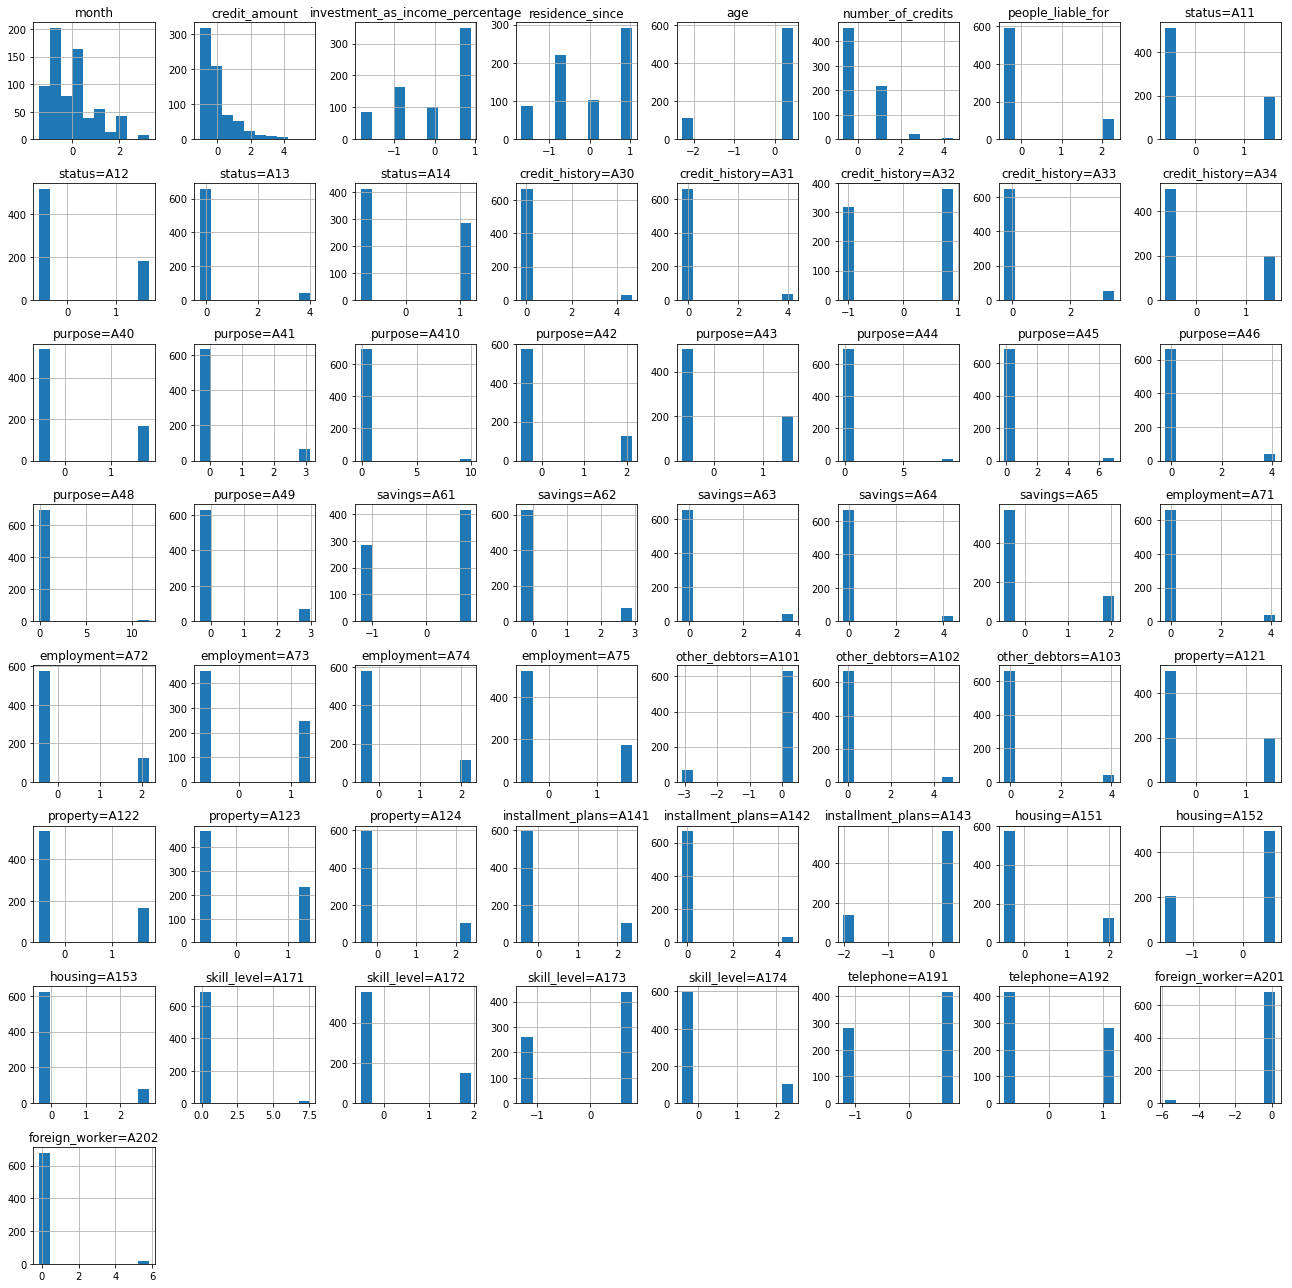

In [20]:
plt.rcParams["figure.figsize"] = (18,18)

scaled_features = pd.DataFrame(X_train, columns=dataset_german.feature_names)

scaled_features.hist();
plt.tight_layout()

<a class="anchor" id="original"></a>
### 4.1 Train on the original data

In [21]:
# Logistic regression classifier and predictions

# create an instance of the model
lmod = LogisticRegression()

# train the model
lmod.fit(X_train, y_train, 
         sample_weight=dataset_german_train.instance_weights)

# calculate predicted labels
y_train_pred = lmod.predict(X_train)

# assign positive class index
pos_ind = np.where(lmod.classes_ == dataset_german_train.favorable_label)[0][0]

# add predicted labels to predictions dataset
dataset_german_train_pred = dataset_german_train.copy()
dataset_german_train_pred.labels = y_train_pred

dataset_german_test_pred = dataset_german_test.copy()
X_test = scale_german.transform(dataset_german_test_pred.features)
y_test_pred = lmod.predict(X_test)
pos_ind_test = np.where(lmod.classes_ == dataset_german_test.favorable_label)[0][0]
dataset_german_test_pred.labels = lmod.predict(X_test)

In [22]:
# model accuracy
score = lmod.score(X_test, y_test)
print(score)

0.7533333333333333


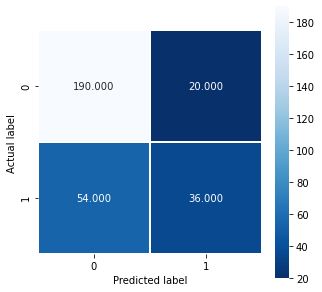

In [23]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, lmod.predict(X_test))

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

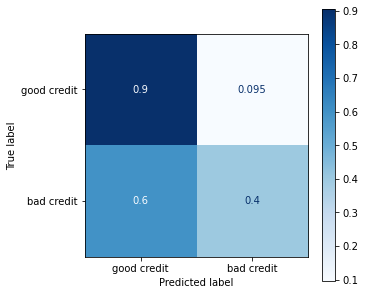

In [24]:
from sklearn.metrics import plot_confusion_matrix

[fig, ax] = plt.subplots(1, figsize=(5, 5));
plot_confusion_matrix(lmod, X_test, y_test,
                      cmap=plt.cm.Blues, 
                      display_labels=['good credit','bad credit'],
                      normalize='true',ax=ax);

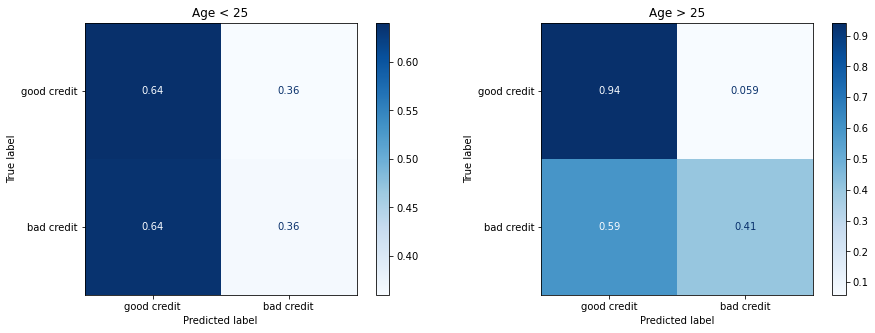

In [25]:
df_test = pd.DataFrame(dataset_german_test.features, columns=dataset_german_test.feature_names)

[fig, ax] = plt.subplots(1,2, figsize=(15, 5));
plot_confusion_matrix(lmod, X_test[df_test['age']==0], y_test[df_test['age']==0],
                      cmap=plt.cm.Blues, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[0],normalize='true');
ax[0].set_title('Age < 25')

plot_confusion_matrix(lmod, X_test[df_test['age']==1], y_test[df_test['age']==1],
                      cmap=plt.cm.Blues, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[1],normalize='true');
ax[1].set_title('Age > 25');

### Model metrics from the [`ClassificationMetric` class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html)

aif360 contains several metrics to compare the bias in the data and the predictions. 

#### Calculate the metrics ob both the training and test data

In [26]:
metric_german_train_pred = ClassificationMetric(dataset_german_train, dataset_german_train_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_german_pred = ClassificationMetric(dataset_german_test, dataset_german_test_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [27]:
display(Markdown("#### Original training dataset"))
print("mean_difference = %f" % metric_german_train.mean_difference())
print("disparate_impact = %f" % metric_german_train.disparate_impact())

display(Markdown("#### Original test dataset"))
print("mean_difference = %f" % metric_german_test.mean_difference())
print("disparate_impact = %f" % metric_german_test.disparate_impact())

display(Markdown("#### Predicted labels (training dataset)"))
print("mean_difference = %f" % metric_german_train_pred.mean_difference())
print("disparate_impact = %f" % metric_german_train_pred.disparate_impact())

display(Markdown("#### Predicted labels (test dataset)"))
print("mean_difference = %f" % metric_german_pred.mean_difference())
print("disparate_impact = %f" % metric_german_pred.disparate_impact())

display(Markdown("#### Quality metrics  (training dataset)"))
print("accuracy = %f" % metric_german_train_pred.accuracy())
print("coefficient_of_variation = %f" % metric_german_train_pred.coefficient_of_variation())
print("error_rate = %f" % metric_german_train_pred.error_rate())

display(Markdown("#### Quality metrics  (test dataset)"))
print("accuracy = %f" % metric_german_pred.accuracy())
print("coefficient_of_variation = %f" % metric_german_pred.coefficient_of_variation())
print("error_rate = %f" % metric_german_pred.error_rate())

#### Original training dataset

mean_difference = -0.169905
disparate_impact = 0.766430


#### Original test dataset

mean_difference = -0.006313
disparate_impact = 0.990991


#### Predicted labels (training dataset)

mean_difference = -0.280261
disparate_impact = 0.650715


#### Predicted labels (test dataset)

mean_difference = -0.198232
disparate_impact = 0.763198


#### Quality metrics  (training dataset)

accuracy = 0.785714
coefficient_of_variation = 0.614531
error_rate = 0.214286


#### Quality metrics  (test dataset)

accuracy = 0.753333
coefficient_of_variation = 0.614232
error_rate = 0.246667


<a class="anchor" id="algorithms"></a>
## 5. AI fairness algorithms

<img src="https://github.com/MargrietGroenendijk/gitbooks2/blob/master/files/pipeline.png?raw=true" width="1000" align="left">

<img src="https://github.com/MargrietGroenendijk/gitbooks2/blob/master/files/algorithms.png?raw=true"  width="1000" align="left">

<a class="anchor" id="preproc"></a>
### 5.1 Pre-processing algorithms

### Remove bias by reweighing data

**Reweighing** is a preprocessing technique that weights the examples in each (group, label) combination differently to ensure fairness before classification.

<div class="alert alert-info" style="font-size:100%">
<b>Read the <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html">aif360 documentation</a> for a full overview<br>
</div>

In [28]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

# compute the weights for reweighing the dataset
RW.fit(dataset_german_train)

# transform the dataset to a new dataset based on the estimated transformation
dataset_rw_train = RW.transform(dataset_german_train)
dataset_rw_test = RW.transform(dataset_german_test)

In [29]:
display(Markdown("#### Original training dataset"))
print("mean_difference = %f" % metric_german_train.mean_difference())
print("disparate_impact = %f" % metric_german_train.disparate_impact())

metric_rw_train = BinaryLabelDatasetMetric(dataset_rw_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

display(Markdown("#### Reweighted training dataset"))
print("mean_difference = %f" % metric_rw_train.mean_difference())
print("disparate_impact = %f" % metric_rw_train.disparate_impact())

#### Original training dataset

mean_difference = -0.169905
disparate_impact = 0.766430


#### Reweighted training dataset

mean_difference = 0.000000
disparate_impact = 1.000000


#### Train on reweighted data

In [30]:
# scale data
scale_rw = StandardScaler().fit(dataset_rw_train.features)

X_train_rw = scale_rw.transform(dataset_rw_train.features)
y_train_rw = dataset_rw_train.labels.ravel()
w_train_rw = dataset_rw_train.instance_weights.ravel()

X_test_rw = scale_rw.transform(dataset_rw_test.features)
y_test_rw = dataset_rw_test.labels.ravel()
w_test_rw = dataset_rw_test.instance_weights.ravel()

In [31]:
dataset_rw_train.instance_weights

array([0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 1.25555556, 0.678     ,
       1.100625  , 1.100625  , 0.96229508, 0.96229508, 1.100625  ,
       0.96229508, 1.25555556, 1.100625  , 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       1.100625  , 0.96229508, 0.96229508, 0.96229508, 0.678     ,
       0.96229508, 0.96229508, 0.678     , 1.100625  , 0.96229508,
       0.678     , 0.96229508, 0.96229508, 1.100625  , 0.96229508,
       1.100625  , 0.96229508, 0.96229508, 1.25555556, 0.96229508,
       0.678     , 1.100625  , 0.96229508, 0.96229508, 1.25555556,
       1.100625  , 1.100625  , 0.96229508, 0.96229508, 1.100625  ,
       0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       1.100625  , 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 1.100625  , 0.678     , 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 0.96229508, 1.25555

In [45]:
# create a new instance of the model
lmod_rw = LogisticRegression()

# train the model
lmod_rw.fit(X_train_rw, y_train_rw, 
         sample_weight=dataset_rw_train.instance_weights)

# calculate predicted labels
y_train_pred_rw = lmod_rw.predict(X_train_rw)

# assign positive class index
pos_ind_rw = np.where(lmod_rw.classes_ == dataset_rw_train.favorable_label)[0][0]

# add predicted labels to predictions dataset
dataset_rw_train_pred = dataset_rw_train.copy()
dataset_rw_train_pred.labels = y_train_pred_rw

dataset_rw_test_pred = dataset_rw_test.copy()
X_test = scale_rw.transform(dataset_rw_test_pred.features)
y_test_pred = lmod.predict(X_test)
pos_ind_test = np.where(lmod_rw.classes_ == dataset_rw_test.favorable_label)[0][0]
dataset_rw_test_pred.labels = lmod_rw.predict(X_test)

In [46]:
# model accuracy
print(score)
score_rw = lmod_rw.score(X_test_rw, y_test_rw)
print(score_rw)

0.7533333333333333
0.7666666666666667


In [47]:
metric_german_train_pred_rw = ClassificationMetric(dataset_rw_train, dataset_rw_train_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_german_pred_rw = ClassificationMetric(dataset_rw_test, dataset_rw_test_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [48]:
display(Markdown("#### Original test dataset"))
print("mean_difference = %f" % metric_german_test.mean_difference())
print("disparate_impact = %f" % metric_german_test.disparate_impact())

display(Markdown("#### Predicted labels (test dataset)"))
print("mean_difference = %f" % metric_german_pred.mean_difference())
print("disparate_impact = %f" % metric_german_pred.disparate_impact())

display(Markdown("#### Predicted labels (reweighted test dataset)"))
print("mean_difference = %f" % metric_german_pred_rw.mean_difference())
print("disparate_impact = %f" % metric_german_pred_rw.disparate_impact())

display(Markdown("#### Quality metrics  (test dataset)"))
print("accuracy = %f" % metric_german_pred.accuracy())
print("coefficient_of_variation = %f" % metric_german_pred.coefficient_of_variation())
print("error_rate = %f" % metric_german_pred.error_rate())

display(Markdown("#### Quality metrics  (reweighted test dataset)"))
print("accuracy = %f" % metric_german_pred_rw.accuracy())
print("coefficient_of_variation = %f" % metric_german_pred_rw.coefficient_of_variation())
print("error_rate = %f" % metric_german_pred_rw.error_rate())

#### Original test dataset

mean_difference = -0.006313
disparate_impact = 0.990991


#### Predicted labels (test dataset)

mean_difference = -0.198232
disparate_impact = 0.763198


#### Predicted labels (reweighted test dataset)

mean_difference = 0.072140
disparate_impact = 1.090629


#### Quality metrics  (test dataset)

accuracy = 0.753333
coefficient_of_variation = 0.614232
error_rate = 0.246667


#### Quality metrics  (reweighted test dataset)

accuracy = 0.764236
coefficient_of_variation = 0.596462
error_rate = 0.235764


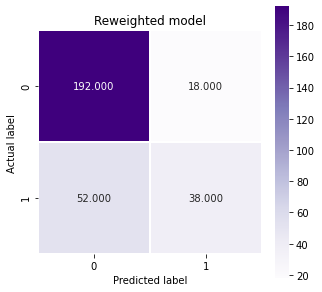

In [49]:
# confusion matrix
cm_rw = metrics.confusion_matrix(y_test_rw, lmod_rw.predict(X_test_rw))

plt.figure(figsize=(5,5))
sns.heatmap(cm_rw, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Purples');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Reweighted model');

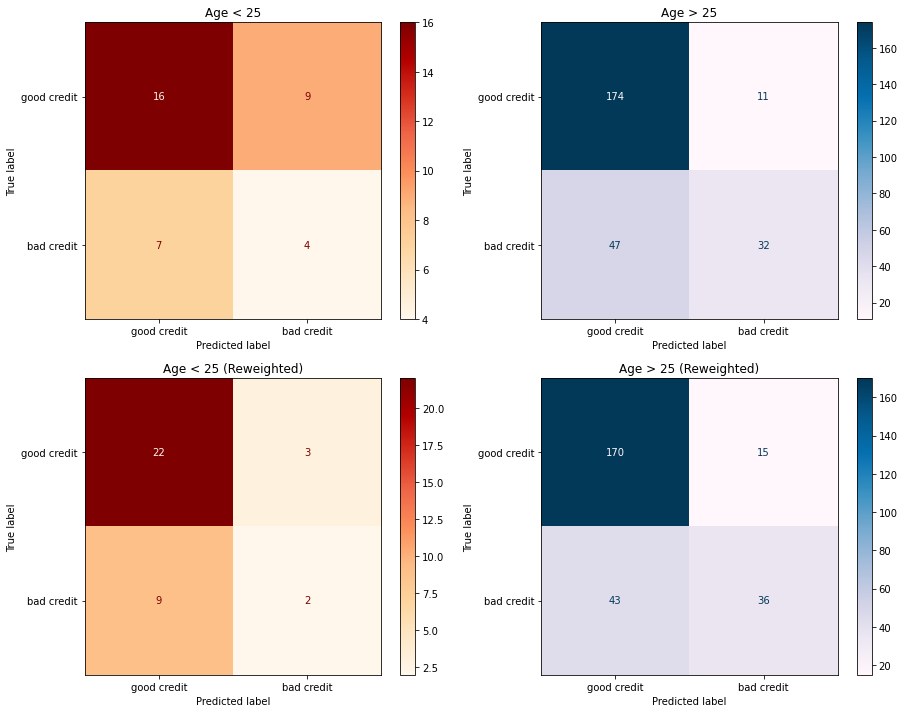

In [50]:
[fig, ax] = plt.subplots(2,2, figsize=(15, 12));
plot_confusion_matrix(lmod, X_test[df_test['age']==0], y_test[df_test['age']==0],
                      cmap=plt.cm.OrRd, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[0,0]);
ax[0,0].set_title('Age < 25')

plot_confusion_matrix(lmod, X_test[df_test['age']==1], y_test[df_test['age']==1],
                      cmap=plt.cm.PuBu, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[0,1]);
ax[0,1].set_title('Age > 25');

plot_confusion_matrix(lmod_rw, X_test_rw[df_test['age']==0], y_test_rw[df_test['age']==0],
                      cmap=plt.cm.OrRd, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[1,0]);
ax[1,0].set_title('Age < 25 (Reweighted)')

plot_confusion_matrix(lmod_rw, X_test_rw[df_test['age']==1], y_test_rw[df_test['age']==1],
                      cmap=plt.cm.PuBu, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[1,1]);
ax[1,1].set_title('Age > 25 (Reweighted)');

In [ ]:
[fig, ax] = plt.subplots(2,2, figsize=(15, 12), sharex=True);
plot_confusion_matrix(lmod, X_test[df_test['age']==0], y_test[df_test['age']==0],
                      cmap=plt.cm.PuBu, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[0,0],normalize='true');
ax[0,0].set_title('Age < 25')

plot_confusion_matrix(lmod, X_test[df_test['age']==1], y_test[df_test['age']==1],
                      cmap=plt.cm.PuBu, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[0,1],normalize='true');
ax[0,1].set_title('Age > 25');

plot_confusion_matrix(lmod_rw, X_test_rw[df_test['age']==0], y_test_rw[df_test['age']==0],
                      cmap=plt.cm.PuBu, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[1,0],normalize='true');
ax[1,0].set_title('Age < 25 (Reweighted)')

plot_confusion_matrix(lmod_rw, X_test_rw[df_test['age']==1], y_test_rw[df_test['age']==1],
                      cmap=plt.cm.PuBu, 
                      display_labels=['good credit','bad credit'],
                      ax=ax[1,1],normalize='true');
ax[1,1].set_title('Age > 25 (Reweighted)');

### Remove bias with the optimized data pre-processing algorithm 

The debiasing function used is implemented in the [OptimPreproc](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.OptimPreproc.html?highlight=get%20distortion) class. It modifies training data features & labels.

* Define parameters for optimized pre-processing specific to the dataset.
* Divide the dataset into training, validation, and testing partitions.
* Learn the optimized pre-processing transformation from the training data.
* Train classifier on original training data.
* Estimate the optimal classification threshold, that maximizes balanced accuracy without fairness constraints (from the original validation set).
* Determine the prediction scores for original testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.
* Transform the testing set using the learned probabilistic transformation.
* Determine the prediction scores for transformed testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.

> Example notebook [here](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb)

This algorithm does not use the privileged and unprivileged groups that are specified during initialization yet. Instead, it automatically attempts to reduce statistical parity difference between all possible combinations of groups in the dataset.

<a class="anchor" id="inproc"></a>
### 5.2 In-processing algorithms

Examples:
* [Adversarial Debiasing](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_adversarial_debiasing.ipynb) - Uses adversarial techniques to maximize accuracy & reduce evidence of protected attributes in predictions
* [Reject Option Classification](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reject_option_classification.ipynb) - Adds a discrimination-aware regularization term to the learning objective

<a class="anchor" id="postproc"></a>
### 5.3 Post-processing algorithms

* [Reject option classification (ROC)](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.postprocessing.RejectOptionClassification.html?highlight=reject) is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.
* [Odds Equalizing](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_calibrated_eqodds_postprocessing.ipynb) modifies the predicted label using an optimization scheme to make predictions fairer


# Beyond accuracy

Tradeoffs – Bias vs. Accuracy

* Is your model doing good things or bad things to people?
    * If your model is sending people to jail, may be better to have more false positives than false negatives     
    * If your model is handing out loans, may be better to have more False Negatives than False Positives
* Determine your threshold for accuracy vs. fairness
    * Doing what is **legal** is top priority 
    * What are the **ethical** guidelines of your company? 
    * Losing the **trust** of your customers is costly 



<a class="anchor" id="resources"></a>
# 5. More resources

* [aif360 demo and resources](http://aif360.mybluemix.net/)
* [aif360 on GitHub](https://github.com/Trusted-AI/AIF360)
* [Python API documentation](https://aif360.readthedocs.io/en/latest/)
* [R documentation](https://github.com/Trusted-AI/AIF360/tree/master/aif360/aif360-r)
* [Medical expenditure tutorial](https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb)

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.